# [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) #

Objetivo é desenvolver um modelo preditivo que responda a questão: que tipos de pessoas tinham mais chance de sobreviver? Usando para isso os dados como nome, idade, gênero, classe sócio econômica, etc.

Resolução baseada no tutorial do [Mario Filho](https://github.com/ledmaster/TutorialTitanic)

## Bibliotecas ##

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression

## Dados ##

Leitura dos dados

In [2]:
data_train = pd.read_csv("data/train.csv")
data_test = pd.read_csv("data/test.csv")

# data_train.head()

Quantizando os dados

In [3]:
def quant_sex(value):
    ''' Change variable Sex from qualitative to quantitative values'''
    if value == 'female':
        return 1
    else:
        return 0
    
variables = ['Sex_bin', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked_S', 'Embarked_C', 'Cabine_nula', 'Nome_contem_Miss', 'Nome_contem_Mrs', 'Nome_contem_Master', 'Nome_contem_Col', 'Nome_contem_Major', 'Nome_contem_Mr']

#
# Treino
#
data_train['Embarked_S'] = (data_train['Embarked'] == 'S').astype(int)
data_train['Embarked_C'] = (data_train['Embarked'] == 'C').astype(int)
# data_train['Embarked_Q'] = (train['Embarked'] == 'Q').astype(int)

data_train['Cabine_nula'] = data_train['Cabin'].isnull().astype(int)

data_train['Nome_contem_Miss'] = data_train['Name'].str.contains("Miss").astype(int)
data_train['Nome_contem_Mrs'] = data_train['Name'].str.contains("Mrs").astype(int)

data_train['Nome_contem_Master'] = data_train['Name'].str.contains("Master").astype(int)
data_train['Nome_contem_Col'] = data_train['Name'].str.contains("Col").astype(int)
data_train['Nome_contem_Major'] = data_train['Name'].str.contains("Major").astype(int)
data_train['Nome_contem_Mr'] = data_train['Name'].str.contains("Mr").astype(int)

data_train['Sex_bin'] = data_train['Sex'].map(quant_sex)
sub_data_train = data_train[variables].fillna(-1)
survived_train = data_train['Survived']

#
# Teste
#
data_test['Embarked_S'] = (data_test['Embarked'] == 'S').astype(int)
data_test['Embarked_C'] = (data_test['Embarked'] == 'C').astype(int)
# data_train['Embarked_Q'] = (train['Embarked'] == 'Q').astype(int)

data_test['Cabine_nula'] = data_test['Cabin'].isnull().astype(int)

data_test['Nome_contem_Miss'] = data_test['Name'].str.contains("Miss").astype(int)
data_test['Nome_contem_Mrs'] = data_test['Name'].str.contains("Mrs").astype(int)

data_test['Nome_contem_Master'] = data_test['Name'].str.contains("Master").astype(int)
data_test['Nome_contem_Col'] = data_test['Name'].str.contains("Col").astype(int)
data_test['Nome_contem_Major'] = data_test['Name'].str.contains("Major").astype(int)
data_test['Nome_contem_Mr'] = data_test['Name'].str.contains("Mr").astype(int)

data_test['Sex_bin'] = data_test['Sex'].map(quant_sex)
sub_data_test = data_test[variables].fillna(-1)


## Modelos ##

### Base ###

Modelo que assume que todas as mulheres sobrevivem

In [4]:
baseline = (data_test['Sex'] == 'female').astype(int)
baseline.index = data_test['PassengerId']
baseline.name = 'Survived'
baseline.to_csv('data/gender_submission_baseline.csv', header = True)

# Imprime os 10 primeiros registros do arquivo
# !head -n10 data/gender_submission.csv

### Random Forest ###

Criando modelo, executando treinamento e predição

In [5]:
model = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 0)

model.fit(sub_data_train, survived_train) 

rf_survived = model.predict(sub_data_test)

# Imprime variavel
# rf_survived

Exportando resultados para formato de [submissão](#subm)

In [6]:
output = pd.Series(rf_survived, index = data_test['PassengerId'], name = 'Survived')
output.to_csv("data/random_forest.csv", header = True)

# !head -n10 data/random_forest.csv

### Regressão Logística ###

Criando modelo, executando treinamento e predição

In [7]:
model = LogisticRegression()

model.fit(sub_data_train, survived_train) 

lr_survived = model.predict(sub_data_test)

# Imprime variavel
# lr_survived

/home/ausabino/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Exportando resultados para formato de [submissão](#subm)

In [8]:
output = pd.Series(lr_survived, index = data_test['PassengerId'], name = 'Survived')
output.to_csv("data/logistic_regression.csv", header = True)

# !head -n10 data/logistic_regression.csv

## Validação ##
### Simples ###

In [9]:
sub_train, sub_valid, sub_surv_train, sub_surv_valid  = train_test_split(sub_data_train, survived_train, test_size = 0.5)

# Imprime dimensões das tuplas
# sub_train.shape, sub_valid.shape, sub_surv_train.shape, sub_surv_valid.shape

# Baseline
baseline = (sub_valid['Sex_bin'] == 1).astype(np.int64)
acc_baseline = np.mean(sub_surv_valid == baseline)

# Random Forest
model_RF = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 0)
model_RF.fit(sub_train, sub_surv_train) 
survived_predicted_valid_RF = model_RF.predict(sub_valid)
acc_rf = np.mean(sub_surv_valid == survived_predicted_valid_RF)

# Logistic Regression
model_LR = LogisticRegression()
model_LR.fit(sub_train, sub_surv_train) 
survived_predicted_valid_LR = model_LR.predict(sub_valid)
acc_lr = np.mean(sub_surv_valid == survived_predicted_valid_LR)

/home/ausabino/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Validação cruzada (KFold Cross Validation) ###

Definir função que executa validação cruzada

In [10]:
def cross_validation(kfold, data, survived, model):
    results = []
    valid_lines = []
    survived_predicted = []
    for train_lines, valid_lines in kfold.split(data):
        # print("Train:", train_lines.shape[0])
        # print("Valid:", valid_lines.shape[0])

        sub_train, sub_valid = data.iloc[train_lines], data.iloc[valid_lines] 
        sub_surv_train, sub_surv_valid =  survived.iloc[train_lines], survived.iloc[valid_lines]

        model.fit(sub_train, sub_surv_train) 
        survived_predicted = model.predict(sub_valid)

        acc = np.mean(sub_surv_valid == survived_predicted)
        results.append(acc)
        # print("Acc:", acc)
        # print()
    return results, valid_lines, survived_predicted

Executar validação cruzada com os modelos definidos

In [11]:
kf = RepeatedKFold(n_splits = 2, n_repeats = 10, random_state = 10)

# Random Forest
model_RF = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 0)
results_kf_rf, valid_lines_rf, survived_predicted_rf = cross_validation(kf, sub_data_train, survived_train, model_RF)
acc_kf_rf = np.mean(results_kf_rf)

# Logistic Regression
model_LR = LogisticRegression()
results_kf_lr, valid_lines_lr, survived_predicted_lr = cross_validation(kf, sub_data_train, survived_train, model_LR)
acc_kf_lr = np.mean(results_kf_lr)

/home/ausabino/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ausabino/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

Exibir valores de acurácia para as validações testadas

In [12]:
print("Baseline\t\t", acc_baseline, "\nRandom Forest\t\t", acc_rf, "\nLogistic Regression\t", acc_lr, "\nKFold RF\t\t", acc_kf_rf, "\nKFold LR\t\t", acc_kf_lr)

Baseline		 0.7825112107623319 
Random Forest		 0.7780269058295964 
Logistic Regression	 0.804932735426009 
KFold RF		 0.8050486219579784 
KFold LR		 0.8181740313397491


## Visualização dos dados ##

Populating the interactive namespace from numpy and matplotlib


((array([1., 0., 1., 2., 0., 4., 5., 3., 1., 3.]),
  array([0.7690583 , 0.77488789, 0.78071749, 0.78654709, 0.79237668,
         0.79820628, 0.80403587, 0.80986547, 0.81569507, 0.82152466,
         0.82735426]),
  <a list of 10 Patch objects>),
 (array([1., 2., 3., 1., 7., 0., 2., 1., 1., 2.]),
  array([0.79775281, 0.80205825, 0.80636368, 0.81066912, 0.81497456,
         0.81927999, 0.82358543, 0.82789087, 0.8321963 , 0.83650174,
         0.84080717]),
  <a list of 10 Patch objects>))

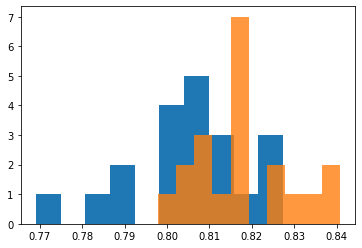

In [13]:
%matplotlib inline
%pylab inline
pylab.hist(results_kf_rf), pylab.hist(results_kf_lr, alpha=0.8)

### Análise de erro ###

In [14]:
data_check = data_train.iloc[valid_lines_rf].copy()
data_check["Predicted"] = survived_predicted_rf
# data_check.head()

errors = data_check[data_check["Survived"] != data_check["Predicted"]]
errors = errors[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex_bin', 'Predicted', 'Survived']]
# errors.head()

In [15]:
women = errors[errors["Sex"] == "female"]
men = errors[errors["Sex"] == "male"]

women.sort_values("Survived")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bin,Predicted,Survived
415,416,3,"Meek, Mrs. Thomas (Annie Louise Rowley)",female,NaN,0,0,343095,8.0500,NaN,S,1,1,0
854,855,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44.0,1,0,244252,26.0000,NaN,S,1,1,0
852,853,3,"Boulos, Miss. Nourelain",female,9.0,1,1,2678,15.2458,NaN,C,1,1,0
772,773,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S,1,1,0
736,737,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.3750,NaN,S,1,1,0
678,679,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9000,NaN,S,1,1,0
654,655,3,"Hegarty, Miss. Hanora ""Nora""",female,18.0,0,0,365226,6.7500,NaN,Q,1,1,0
593,594,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,NaN,Q,1,1,0
502,503,3,"O'Sullivan, Miss. Bridget Mary",female,NaN,0,0,330909,7.6292,NaN,Q,1,1,0
501,502,3,"Canavan, Miss. Mary",female,21.0,0,0,364846,7.7500,NaN,Q,1,1,0


In [16]:
men.sort_values("Survived")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bin,Predicted,Survived
452,453,1,"Foreman, Mr. Benjamin Laventall",male,30.0,0,0,113051,27.7500,C111,C,0,1,0
757,758,2,"Bailey, Mr. Percy Andrew",male,18.0,0,0,29108,11.5000,NaN,S,0,1,0
749,750,3,"Connaghton, Mr. Michael",male,31.0,0,0,335097,7.7500,NaN,Q,0,1,0
745,746,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S,0,1,0
698,699,1,"Thayer, Mr. John Borland",male,49.0,1,1,17421,110.8833,C68,C,0,1,0
671,672,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S,0,1,0
544,545,1,"Douglas, Mr. Walter Donald",male,50.0,1,0,PC 17761,106.4250,C86,C,0,1,0
442,443,3,"Petterson, Mr. Johan Emil",male,25.0,1,0,347076,7.7750,NaN,S,0,1,0
238,239,2,"Pengelly, Mr. Frederick William",male,19.0,0,0,28665,10.5000,NaN,S,0,1,0
169,170,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S,0,1,0


## <a name="subm"></a> Submissão ##

In [17]:
predicted = rf_survived
file_submit = pd.Series(predicted, index = data_test["PassengerId"], name = "Survived" )
file_submit.to_csv("data/titanic_prediction.csv", header = True)

# head -n10 data/titanic_prediction.csv